# Project EVA_DMBEM Basic shape building thermal analysis. 


Barbara Klemensowska, 02.12.2022












# Thermal circuit and state-space representation for a thermal circuit with capacities in some nodes: cubic building
**Objectives:**
- Analysis a cubic building with 3 identical walls & two transparent walls (glass windows).
- Modeling the heat transfer in the building by a thermal circuit.
- Obtaining the mathematical model as a system of Differential Algebraic Equations (DAE) from the thermal circuit.
- Transfroming the system of DAE into state-space representation.
- Findind the steady-state solution.
- Simulating by using Euler methods for numerical integration.



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dm4bem


# Physical analysis


### Description of the building

![cube](./model_cube.png)
> Figure 1. Simple insulatet room (2 glass window, wooden wall with adjoining room) 

Let’s consider a two cells building.

In [2]:
import pandas as pd
wall = {'Conductivity': [1.400, 0.12, 1],
        'Density': [2300.0, 240, 2210.0],
        'Specific heat': [880, 1400, 753],
        'Width': [0.2, 0.5, 0.002],
        'Meshes': [4, 2, 2]}
wall = pd.DataFrame(wall, index=['Concrete', 'Wood', 'Glass'])
wall

,Conductivity,Density,Specific heat,Width,Meshes
Concrete,1.40,2300.0,880,0.200,4
Wood,0.12,240.0,1400,0.500,2
Glass,1.00,2210.0,753,0.002,2


The dimensions and surface areas of the building are:
- $l=3 \: \mathrm{m}$ - edge length of the cube;
- $S_g=l^2$   - surface area of the glass window;
- $S_c = S_i = 1 \times S_g$   - surface area of the wooden wall

In [3]:
l = 3               # m length of the cubic room
Sg = l**2           # m² surface of the glass wall
Sc = 1 * Sg         # m² surface of the wooden wall


The thermo-physical properties of the air (in SI units) are:



In [4]:
air = {'Density': 1.2,                      # kg/m³
       'Specific heat': 1000}               # J/(kg·K)
# pd.DataFrame.from_dict(air, orient='index', columns=['air'])
pd.DataFrame(air, index=['Air'])


,Density,Specific heat
Air,1.2,1000


Thermo-properties of the walls

In [5]:
wall = {'Conductivity': [1.4, 0.12, 1],  # W/(m·K)
        'Density': [2300, 240, 2210],        # kg/m³
        'Specific heat': [880, 1400, 753],  # J/(kg·K)
        'Width': [0.2, 0.5, 0.002],
        'Surface': [1 * l**3, 1 * l**3, l**3],  # m²
        'Meshes': [4, 2, 2]}                # number of  slices
wall = pd.DataFrame(wall, index=['Concrete', 'Wood', 'Glass'])
wall


,Conductivity,Density,Specific heat,Width,Surface,Meshes
Concrete,1.40,2300,880,0.200,27,4
Wood,0.12,240,1400,0.500,27,2
Glass,1.00,2210,753,0.002,27,2


The radiative properties of the surfaces are:

- long wave emmisivity of concrete (between normal and rough) and glass pyrex;
- short wave absortivity of solar radiation of white smooth surfaces;
- short wave transmittance of window glass (thickness of 4 mm);
- short wave absortivity and transmittance of reflective blue window glass.


In [6]:
ε_wLW = 0.85    # long wave emmisivity: wall surface (concrete)
ε_gLW = 0.90    # long wave emmisivity: glass pyrex
α_wSW = 0.25    # short wave absortivity: white smooth surface
α_gSW = 0.38    # short wave absortivity: reflective blue glass
τ_gSW = 0.30    # short wave transmitance: reflective blue glass


Stefan Bolzman constant: between wall and the glass


In [7]:
σ = 5.67e-8     # W/(m²⋅K⁴) Stefan-Bolzmann constant
print(f'σ = {σ} W/(m²⋅K⁴)')

σ = 5.67e-08 W/(m²⋅K⁴)


The view factor between the wall and the glass window is:

In [8]:
Fwg = 1 / 5     # view factor wall - glass
Fwg


0.2

Conventional values for the convection coeficients for indoor and outdoor convection in W/(m²⋅K) are:

In [9]:
h = pd.DataFrame([{'in': 8., 'out': 25}], index=['h'])  # W/(m²⋅K)
h

,in,out
h,8.0,25


## Thermal circuit

Heat transfert is:
- through the walls (concrete and insulation), 
- through the glass window,
- from indoor auxiliary sources,

There is long wave radiative exchange between the wall and the glass window. The sources are:
- temperature sources:
    - outdoor atmospheric air;
    - indoor air temperature setpoint;
- flow rate sources:
    - solar radiation on the outdoor and the indoor walls;
    - auxiliary heat gains in the thermal zone.

### Thermal Circuit
![thermal circuit1](./thermal_circuit1.png)
> Figure 2.Thermal circuit for the cubic building shown in Figure 1.




## Thermal coductances

#### Conduction
Conduction conductances, in W/K, are of the form:
# $$G_{cd} = \frac{\lambda}{w}S$$
# where:
# 
# - $\lambda$ - [thermal conductvity](https://en.m.wikipedia.org/wiki/Thermal_conductivity), W/(m⋅K);
# - $w$ - width of the material, m;
# - $S$ - surface area of the wall, m².

In [10]:
# Conduction
G_cd = wall['Conductivity'] / wall['Width'] * wall['Surface']
pd.DataFrame(G_cd, columns={'Conductance'})

,Conductance
Concrete,189.00
Wood,6.48
Glass,13500.00


#### Convection
Convection conductances, in W/K, are of the form:
$$G_{cv} = {h S}$$
where:
- $h$ is the [convection coefficient](https://en.m.wikipedia.org/wiki/Heat_transfer_coefficient), W/(m²⋅K);
- $S$ - surface area of the wall, m². 

In [11]:
# Convection
Gw = h * wall['Surface'][0]     # wall
Gg = h * wall['Surface'][2]     # glass
Gwood = h * wall['Surface'][1]  # wooden wall

####  Long wave radiation

The long-wave heat exchange between surfaces may be modelled by using the concept of [radiosity](https://en.m.wikipedia.org/wiki/Radiosity_(radiometry)) and then linearizing the radiative heat exchange. 

 ![LW_rad_excg](./figures/03_LW_rad_excg.png)
> Figure 3. Radiative long-wave heat exchange between two surfaces: a) modeled by [emmitance](https://en.m.wikipedia.org/wiki/Radiant_exitance) (source) and [radiosity](https://en.m.wikipedia.org/wiki/Radiosity_(radiometry)) (nodes); b) modeled by linearization of emmitance (temperature sources) and radiosity (temperature nodes).

For two surfaces the [conductances](https://en.m.wikipedia.org/wiki/Radiosity_(radiometry)#Circuit_analogy), in m², for radiative heat exchange expressed by using the emmitance (or the [radiant excitance](https://en.m.wikipedia.org/wiki/Radiant_exitance))  of the black body, the [radiosity](https://en.m.wikipedia.org/wiki/Radiosity_(radiometry)), and the [reciprocity](https://en.m.wikipedia.org/wiki/View_factor#Reciprocity) of view factors are:

$$G_{1}^{r} = \frac{\varepsilon_1}{1 - \varepsilon_1} S_1$$

$$G_{1,2}^{r} = F_{1,2} S_1 = F_{2,1} S_2$$

$$G_{2}^{r} = \frac{\varepsilon_2}{1 - \varepsilon_2} S_2$$

where:
- $\varepsilon_1$ and $\varepsilon_2$ are the [emmisivities](https://en.m.wikipedia.org/wiki/Emissivity) of the surfaces 1 and 2;
- $S_1$ and $S_2$ - areas of the surfaces 1 and 2, m²;
- $F_{1,2}$ - [view factor](https://en.m.wikipedia.org/wiki/View_factor) between surfaces 1 and 2.

The [net flows leaving the surfaces 1 and 2](https://en.m.wikipedia.org/wiki/Radiosity_(radiometry)#Circuit_analogy) are:
​
$$q_{net,1} = \frac{\varepsilon_1}{1 - \varepsilon_1} S_1 (M^o_1 - J_1)= G^r_1 (M_1^o - J_1)$$
​
$$q_{net,2} = \frac{\varepsilon_2}{1 - \varepsilon_2} S_2 (M^o_2 - J_2)= G^r_2 (M_2^o - J_2)$$
​
respectively, where:
- $M^o_1$ and $M^o_2$ are the [emmitances](https://en.m.wikipedia.org/wiki/Radiant_exitance) of the surfaces 1 and 2 when emmiting as black bodies, $M^o = \sigma T^4$, W/m²;
- $J_1$ and $J_2$ - [radiosities](https://en.m.wikipedia.org/wiki/Radiosity_(radiometry)) of surfaces 1 and 2, W/m²;
- $G^r_1$ and $G^r_2$ - conductances for long wave radiative heat exchange, m².
​
The [net flow between surfaces 1 and 2](https://en.m.wikipedia.org/wiki/Radiosity_(radiometry)#Circuit_analogy) is:
​
$$q_{1,2} = F_{1,2} S_1 (J_1 - J_2) = F_{2,1} S_2 (J_1 - J_2)= G_{1,2}^r (J_1 - J_2)$$
​
In order to express the long-wave radiative exchange as a function of temperature differences, a linearization of the difference of temperatures $T_1^4 - T_2^4$ may be used:
​
$$T_1^4 - T_2^4 = (T_1^2 + T_2^2)(T_1^2 - T_2^2) = (T_1^2 + T_2^2)(T_1 + T_2)(T_1 - T_2) = 4 \bar{T}^3 (T_1 - T_2)$$
​
where the mean temperature $\bar{T}$, measured in kelvin, is:
​
$$\bar{T} =\sqrt[3]{ \frac{(T_1^2 + T_2^2)(T_1 + T_2)}{4}}$$
​
The evaluation of mean temperaure, $\bar{T}$, requires the values of the surface tempetratures, $T_1$ and $T_2$. An initial guess can be used (and then an iterative process, for a more precise evaluation).
​
After linearization, the conductances, in W/K, for radiative heat exchange are:
​
$$G_{1} = 4 \sigma \bar{T}^3 \frac{\varepsilon_1}{1 - \varepsilon_1} S_1$$
​
$$G_{1,2} = 4 \sigma \bar{T}^3 F_{1,2} S_1 = 4 \sigma \bar{T}^3 F_{2,1} S_2$$
​
$$G_{2} = 4 \sigma \bar{T}^3 \frac{\varepsilon_2}{1 - \varepsilon_2} S_2$$

In [12]:
Tm = 12 + 273   # K, mean temp for radiative exchange

GLW1 = 4 * σ * Tm**3 * ε_wLW / (1 - ε_wLW) * wall['Surface']
GLW12 = 4 * σ * Tm**3 * Fwg * wall['Surface']
GLW2 = 4 * σ * Tm**3 * ε_gLW / (1 - ε_gLW) * wall['Surface']['Glass']

The equivalent conductance, in W/K, for the radiative long-wave heat exchange between the wall and the glass window is:
$$G = \frac{1}{1/G_1 + 1/G_{1,2} + 1/G_2}$$

In [13]:
GLW = 1 / (1 / GLW1 + 1 / GLW12 + 1 / GLW2)

### Heat flow rate sources
The [heat flow rate sources](https://en.m.wikipedia.org/wiki/Current_source#Background) model flow rates which vary idependently of what happens in the themal circuit. They are inputs of the physical model. Generally, the heat flow rate sources are:
- solar radiation absorbed by the walls;
- internal auxiliary sources.

#### Solar radiation absorbed by the walls

The [direct](https://en.m.wikipedia.org/wiki/Direct_insolation), diffuse and reflected components of the [solar radiation](https://en.m.wikipedia.org/wiki/Solar_irradiance) on a tilted surface can be estimated from weather data by using the function `sol_rad_tilt_surf` from the module `dm4bem` (see the tutorial on [Weather data and solar radiation](../t01/t01ReadWeatherData.ipynb)).

##### External wall

The radiation absorbed by the outdoor surface of the wall is:

$$\Phi_o = \alpha_{w,SW} S_w E_{tot}$$

where:
- $\alpha_{w,SW}$ is the [absorptance](https://en.m.wikipedia.org/wiki/Absorptance) of the outdoor surface of the wall in short wave, $0 \leqslant \alpha_{w,SW} \leqslant 1$;
- $S_w$ - surface area of the wall, m²;
- $E_{tot}$ - total [solar irradiance](https://en.m.wikipedia.org/wiki/Solar_irradiance) on the wall, W/m².

## System of algebraic-differential equations (DAE)

The analysis of a thermal circuit, or the direct problem ([Ghiaus 2022](https://hal.archives-ouvertes.fr/hal-03484064/document)), means to find the temperatures in the nodes, $\theta$, and the heat flows on the branches, $q$, i.e. to solve for $\theta$ and $q$ the system of [Differential-Algebraic Equations (DAE)](https://en.m.wikipedia.org/wiki/Differential-algebraic_system_of_equations) :

$$\left\{\begin{array}{ll}
C \dot{\theta} = -(A^T G A) \theta + A^T G b + f\\ 
q = G (-A \theta + b)
\end{array}\right.$$

where:
- $\theta$ is the temperature vector of size $n_\theta$ equal to the number of nodes;
- $q$ - heat flow vector of size $n_q$ equal to the number of branches;
- $A$ - [incidence matrix](https://en.m.wikipedia.org/wiki/Incidence_matrix) of size $n_q$ rows and $n_{\theta}$ columns, where $n_q$ is the number of flow branches and $n_{\theta}$  is the number of temperature nodes. It shows how the temperature nodes are connected by oriented branches of heat flows:
    - if flow *m* enters into node *n*, then the element (*m, n*) of the matrix $A$ is 1, i.e., $A_{m,n} = 1$;
    - if flow *m* exits from node *n*, then the element (*m, n*) of the matrix $A$ is -1, i.e., $A_{m,n} = -1$, ; 
    - if flow *m* is not connected to node *n*, then the element (*m, n*) of the matrix $A$ is 0, i.e., $A_{m,n} = 0$.
- $G$ - conductance diagonal matrix of size $n_q \times n_q$,  where $n_q$ is the number of flow branches: diagonal matrix containing the conductances. Each branch $k$ needs to contain a conductance $0 < G_{k,k} < \infty $. 

- $C$ - capacity diagonal matrix of size $n_θ \times n_θ$,  where $n_θ$ is the number of temperature nodes: diagonal matrix containing the capacities. If there is no capacity in the node *n*, then $C_{n, n} = 0$.

- $b$ - temperature source vector of size $n_q$: if there is no temperature source on the branch *m*, then $b_m = 0$.

- $f$ - heat flow source vector of size $n_θ$: if there is no heat flow source in the node *n*, then $f_n = 0$.

The resolution is first done for temperatures, $\theta$, by solving the equation
$$C \dot{\theta} = -(A^T G A) \theta + A^T G b + f$$
which, generally, is a system of differential-algebraic equations (DAE). Then, the heat flow rates are found from the equation
$$q = G (-A \theta + b)$$

![thermal_circuit](./figures/03_TCmatrices.png)
> Figure 4. Matrices of the system of Differential-Algebraic Equations (DAE) 
\begin{aligned}
  &C \dot{\theta} = -(A^T G A) \theta + A^T G b + f \\
  &q = G (-A \theta + b)
\end{aligned}

### A: incidence matrix

The [incidence matrix](https://en.m.wikipedia.org/wiki/Incidence_matrix) of the themal circuit is:

In [14]:
A = np.zeros([11, 8])       # n° of branches X n° of nodes
A[0, 0] = 1
A[1, 0], A[1, 1] = 1, 0    # branch 1: node 0 -> node 1
A[2, 1], A[2, 2] = 1, 0    # branch 2: node 1 -> node 2
A[3, 1], A[3, 2] = -1, 1    # branch 3: node 2 -> node 3
A[4, 2], A[4, 3] = -1, 1    # branch 4: node 3 -> node 4
A[5, 0], A[5, 3] = 1, -1    # branch 5: node 4 -> node 5
A[6, 4] = 1    # branch 6: node 4 -> node 6
A[7, 4], A[7, 5] = -1, 1    # branch 7: node 5 -> node 6
A[8, 5], A[8,6] = -1, 1                 # branch 8: -> node 7
A[9, 6], A[9, 7] = -1, 1    # branch 9: node 5 -> node 7
A[10, 0] = 1 
A[10, 7] = -1               # branch 11: -> node 6
np.set_printoptions(suppress=False)
pd.DataFrame(A) 

,0,1,2,3,4,5,6,7
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0
5,1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0


### G: conductance matrix

The conductance matrix of the themal circuit is:

In [15]:
# glass: convection outdoor & conduction 0
hin = 6
hout = 25
λ = 1
w = 0.002
S = 9
Ggs = float(1 / (1 / Gg['out'] + 1 / (2 * G_cd['Glass'])))
G_wout = hout * S
G_cd_glass = λ / w * S
G_w_in = hin * S 
G_eg0 = 1 / ( 1 / G_wout + 1 / G_cd_glass + 1 / G_w_in)


In [16]:
# wooden wall: convection room 2 & conduction wood 
λ_wood = 0.12
w_wood = 0.5
hout = 25
S = 9

G_room2 = hout * S
G_cd_wood = λ_wood / w_wood * S
G_eg1 = 1 / ( 1 / G_cd_wood + 1 / G_room2)

# wooden wall: conduction wood & convection room 1  

G_cd_wood = λ_wood / w_wood * S
G_eg2 = 1 / ( 1 / G_cd_wood)

# convection in room 1
hout = 25
S = 9
G_room1 = hout * S

# ground 3, dry area
λ_d_g = 0.5
w_d_g = 0.5

G_d_g = λ_d_g / w_d_g * S
G_eg3 = G_d_g

# ground 2, moist area
λ_m_g = 1
w_m_g = 0.3

G_m_g = λ_m_g / w_m_g * S
G_eg4 = G_m_g

# ground 1, stone
λ_s_g = 1.7
w_s_g = 0.4

G_s_g = λ_s_g / w_s_g * S
G_eg5 = G_s_g

# ground 0, sand
λ_sd_g = 0.2
w_sd_g = 0.3

G_sd_g = λ_sd_g / w_sd_g * S
G_eg6 = G_sd_g

# ground floor, concrete 
λ_c = 1.4
w_c = 0.2

G_c = λ_c / w_c * S
G_eg7 = G_c

G = np.diag([G_eg0, G_eg0, G_eg1, G_eg2, G_eg2, G_room1, G_eg3, G_eg4, G_eg5, G_eg6, G_eg7])


### C: capacity matrix

The capacity matrix of the themal circuit

In [17]:
### Thermal capacities
#### Walls

# floor capacity
ρ_floor = 1440
c_floor = 1000

C_w = ρ_floor * c_floor * S * w_c

### Air

# air capacity

x_a1 = 3
ρ_a = 1.168
c_a = 1000

C_a = ρ_a * c_a * S * x_a1

# wood capacity

x_w = 0.5
ρ_w = 240
c_wo = 1400

C_wo = ρ_w * c_wo * S * x_w

# ground 2, moist area

x_m = 0.3
ρ_m = 1500
c_m = 950

C_m = ρ_m * c_m * S * x_m

# ground 1, sand

x_s = 0.2
ρ_s = 1400
c_s = 800

C_s = ρ_s * c_s * S * x_s

C = np.diag([0, 0, C_w, 0, C_wo, C_m, C_s, 0])

### b: temperature source vector¶
The vector of temperature sources is  𝑏 , of size  𝑛𝑞 , the number of branches (in this example 12). An element of the vector  𝑏  corresponding to a branch without a source is zero. If the flow in a source is from the low potential to the high potential of the source (i.e. from - to +), then the source is positive. If the flow rate in the temperature source is from high potential to low potential (i.e. from + to -), then the source is negative (see passive sign convention).

$$b = [\begin{matrix}
T_o   &T_o  &T_1  &0  &0  &0  &T_2 &0 &0 &0 &0  
\end{matrix}]^T$$

i.e. $b_0 = b_1 = T_o$  where:
- $T_o$ is the outdoor temperature, °C;
- $T_2$ - ground temperaure, °C.

In [18]:
#Temperature sources vector
b = np.zeros(11)        # branches
b[[0, 1, 2]] = 12       # branches with temperature sources
b[6] = 5
print(f'b = ', b)





b =  [12. 12. 12.  0.  0.  0.  5.  0.  0.  0.  0.]


### f: heat flow source vector

The vector of *heat sources* is $f$, of size $n_{\theta}$, the number of nodes. An element of the vector $f$ corresponding to a node without a heat source is zero

$$f = [\begin{matrix}
0  &0  &0  &\Phi_3  &0 &0 &0 &\Phi_7 
\end{matrix}]^T$$

- $\Phi_3$ - solar radiation absorbed by the indoor surface of the wall, W;
- $\Phi_7$ - solar radiation reflected by the indoor surface of the wall, W;


In [19]:
#Flow sources vector
f = np.zeros(8)         # nodes
f[[3, 7]] = 1           # nodes with heat-flow sources
print(f'f = ', f)



f =  [0. 0. 0. 1. 0. 0. 0. 1.]


### y: output vector

The vector of outputs is $y$, of size $n_{\theta}$, the number of nodes. The non-zero values of $y$ indicate the nodes which are the outputs of the model.

For the thermal circuit :

$$y = [\begin{matrix}
\theta_0 &0  &0  &0  &0  &0  &0  &0 
\end{matrix}]^T$$

In [20]:
y = np.zeros(8)         # nodes that I want to investigate
y[0] = 1             


## State-space representation
The [differential-algebraic system of equations (DAE)](https://en.m.wikipedia.org/wiki/Differential-algebraic_system_of_equations)

$$C \dot{\theta} = -(A^T G A) \theta + A^T G b + f$$

is transformed in [state-space representation](https://en.m.wikipedia.org/wiki/State-space_representation) ([Ghiaus 2013](https://hal.archives-ouvertes.fr/hal-03605823/document)):

$$\left\{\begin{array}{rr}
\dot{\theta}_s=A_s \theta_C + B_s u\\ 
y = C_s \theta_s + D_s u
\end{array}\right.$$

where:
- $\theta_s$ is the vector of state variables which are the temperatures of nodes containing capacities; the elements are in the same order as in the vector of temperatures, $\theta$; its dimension, $\dim \theta_s$, is equal to the number of capacities from the thermal network; 

- $u = \begin{bmatrix} b_T \\ f_Q\end{bmatrix}$ - vector of inputs of dimension $\dim u$ equal to the number of sources (of temperaure and heat flows) of the thermal network, where:

    
- $y$ - vector of outputs is a subset of vector $\theta$ representing temperature nodes which are of interest; 

- $A_s$ - state matrix, of dimension $\dim A_s = \dim {\theta_s} \times \dim {\theta_s}$;

- $B_s$ - input matrix, of dimension $\dim B_s = \dim {\theta_s} \times \dim u$;

- $C_s$ - output matrix, of dimension $\dim C_s = \dim y \times \dim {\theta_s}$;

- $D_s$ - feedthrough (or feedforward) matrix, of dimension $\dim D_s = \dim y \times \dim u$.

*Note*: The subscript $s$ of the matrices $A_s, B_s, C_s, D_s$ is used to differentiante the matrices $A_s, C_s$ of the state-space represenation of the matrices $A, C$ of the system of DAE.

## Steady-state

In [steady-state](https://en.m.wikipedia.org/wiki/Steady_state), the model can be checked if it is incorrect.

In [21]:
#The outdoor temperature is  𝑇𝑜=12∘C , i.e.  𝑏0=12 .

θ_steady_To = np.linalg.inv(A.T @ G @ A) @ (A.T @ G @ b + f)
np.set_printoptions(precision=3)
print('When To = 12°C, the temperatures in steady-state are:', θ_steady_To, '°C')
print(f'The indoor temperature is: {θ_steady_To[-1]:.3f} °C')


[As, Bs, Cs, Ds] = dm4bem.tc2ss(A, G, b, C, f, y)

When To = 12°C, the temperatures in steady-state are: [11.801 11.935 11.871 11.806  7.145  7.788  8.293 11.51 ] °C
The indoor temperature is: 11.510 °C


## Dynamic simulation

### Time step

The condition for [numerical stability](https://en.m.wikipedia.org/wiki/Euler_method#Numerical_stability) of [Euler explicit integration](https://en.m.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations#Euler_method) method is

$$\left |  \lambda_i \Delta t + 1 \right | < 1, \forall \lambda_i, $$

i.e. in the complex plane, $\lambda_i \Delta t$ is inside a circle of radius 1 centered in {-1, 0j}, where:
- $\lambda_i$ are the eigenvalues of matrix $A_s$,
- $\Delta t$ - time step.

For positive real eigenvalues $\left \{ \lambda \in \Re |\lambda >0  \right \}$, which is the case of thermal networks, the above condition [becomes](http://www.math.iit.edu/~fass/478578_Chapter_4.pdf)

$$- \lambda_i \Delta t - 1  < 1, \forall \lambda_i, $$

or

$$ 0 < \Delta t < -\frac{2}{\min \lambda_i} = \min -2 / \lambda_i = \min 2 T_i$$

where $T_i$ are the [time constants](https://en.m.wikipedia.org/wiki/Time_constant), $T_i = - \frac{1}{\lambda_i} $

In [22]:
λ = np.linalg.eig(As)[0]    # minimum eigenvalue of matrix A
max_Δt = min(-2 / λ)

np.set_printoptions(precision=1)
print('Time constants: \n', -1 / λ, 's \n')
print('2 x Time constants: \n', -2 / λ, 's \n')
print(f'Max time step Δt = {max_Δt:.2f} s')

#We choose a time step smaller than the maximum admited for stability:
Δt = 3600 #1h as reasonable range
# Δt = 50620.20764
print(f'Δt = {Δt} s')


Time constants: 
 [819891.5 567362.   42028.1  25310.1] s 

2 x Time constants: 
 [1639783.1 1134724.    84056.1   50620.2] s 

Max time step Δt = 50620.21 s
Δt = 3600 s


### Settling time
The [settling time](https://en.m.wikipedia.org/wiki/Step_response) is roughly 4 times the larger time constant.

In [23]:
#Settling time 
t_resp = 4 * max(-1 / λ)
print('Time constants: \n', -1 / λ, 's \n')
print(f'Settling time: {t_resp:.0f} s = {t_resp / 60:.1f} min \
= {t_resp / (3600):.2f} h = {t_resp / (3600 * 24):.2f} days')

Time constants: 
 [819891.5 567362.   42028.1  25310.1] s 

Settling time: 3279566 s = 54659.4 min = 910.99 h = 37.96 days


### Step response
Let's obtain the dynamic response of the system to a [step input](https://en.m.wikipedia.org/wiki/Step_response).

#### Duration
The duration of the simulation needs to be larger than the estimated [settling time](https://en.m.wikipedia.org/wiki/Settling_time). This requires a corresponding number of time steps in the time vector.

In [24]:
#Step response - dynamic response - duration
duration = 3600 * 24 * 2            # seconds, larger than response time
n = int(np.floor(duration / Δt))    # number of time steps
t = np.arange(0, n * Δt, Δt)        # time vector for n time steps

print(f'Duration = {duration} s')
print(f'Number of time steps = {n}')
pd.DataFrame(t, columns=['time'])


Duration = 172800 s
Number of time steps = 48


,time
0,0
1,3600
2,7200
3,10800
4,14400
5,18000
6,21600
7,25200
8,28800
9,32400


#### Input vector
In dynamic simulation, the inputs are [time series](https://en.m.wikipedia.org/wiki/Time_series), e.g., the oudoor temperature will have $n$ values $T_o = [T_{o(0)}, T_{o(1)}, ..., T_{o(n-1)}]^T$ at [discrete time](https://en.m.wikipedia.org/wiki/Discrete_time_and_continuous_time#Discrete_time) $t = [t_0, t_1, ... , t_{n-1}]^T$.

The input vector $u$ of the state-space representation is obtained by stacking the vectors $b_T$ and $f_Q$ of the system of Differential Algebraic Equations:

$$u = \begin{bmatrix} b_T \\ f_Q\end{bmatrix}$$
where:
- vector $b_T$ consists of the nonzero elements of vector $b$ of temperature sources
- vector $f_Q$ consists of the nonzero elements of vector $f$ of flow sources

In [25]:
u = np.zeros([6, n])                # u = [To To T1 T2 Φ3 Φ7]
u[0:3, :] = 12 * np.ones([3, n])    # To = 12 for n time steps
u[3, :] = 5 * np.ones([1, n])       # fi_3,7 = 5 for n time steps
print('u = ')
pd.DataFrame(u)

u = 


,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,...,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0
1,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,...,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0
2,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,...,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0
3,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Time integration

By integrating the state-space model

$$\left\{\begin{array}{rr}
\dot{\theta}_C=A_s \theta_C + B_s u\\ 
y = C_s \theta_C + D_s u
\end{array}\right.$$

by using [Euler forward (or explicit) method](https://en.m.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations#Euler_method) for numerical integration:

$$ \theta_{s,k+1} = (I + \Delta t A) \theta_{s,k} + \Delta t B u_k $$

and [Euler backward (or implicit) method](https://en.m.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations#Backward_Euler_method) for numerical integration:

$$\theta_{s,k+1} = (I - \Delta t A)^{-1} ( \theta_{s,k} + \Delta t B u_k )$$

where $k = 0, ... , n - 1$,

In [26]:
#Time integration
n_s = As.shape[0]                      # number of state variables
θ_exp = np.zeros([n_s, t.shape[0]])    # explicit Euler in time t
θ_imp = np.zeros([n_s, t.shape[0]])    # implicit Euler in time t

I = np.eye(n_s)                        # identity matrix

for k in range(n - 1):
    θ_exp[:, k + 1] = (I + Δt * As) @\
        θ_exp[:, k] + Δt * Bs @ u[:, k]
    θ_imp[:, k + 1] = np.linalg.inv(I - Δt * As) @\
        (θ_imp[:, k] + Δt * Bs @ u[:, k])

we obtain the outputs

$$ y = C_s \theta_s + D_s u$$

for explicit and for implicit Euler methods, respectively.

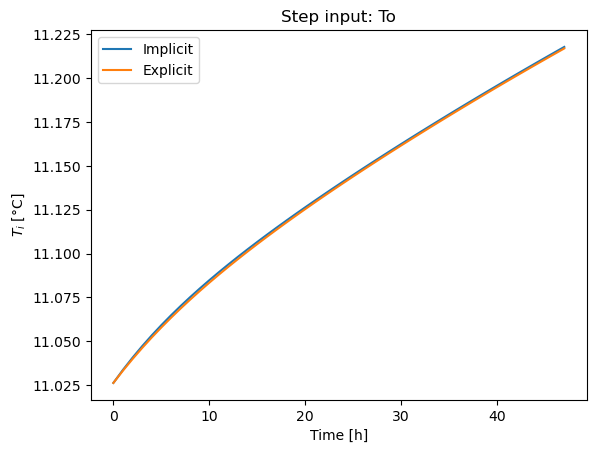

In [27]:
#The outputs we obtain
y_exp = Cs @ θ_exp + Ds @  u
y_imp = Cs @ θ_imp + Ds @  u


#Step response to outdoor temperature by using Euler
fig, ax = plt.subplots()
ax.plot(t / 3600, y_exp.T, t / 3600, y_imp.T)
ax.set(xlabel='Time [h]',
       ylabel='$T_i$ [°C]',
       title='Step input: To')
ax.legend(['Implicit', 'Explicit'])
plt.show()

> Figure 5. Step response to outdoor temperature by using Euler
[implicit](https://en.m.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations#Backward_Euler_method)
and
[explicit](https://en.m.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations#Euler_method) integration.

The results of explicit and implicit Euler integration are practically identical.

In [28]:
print('Steady-state indoor temperature obtained with:')
#print(f'- DAE model: {float(θ[6]):.4f} °C')
#print(f'- state-space model: {float(yss):.4f} °C')
print(f'- steady-state response to step input: {float(y_exp[:, -2]):.4f} °C')


Steady-state indoor temperature obtained with:
- steady-state response to step input: 11.2148 °C


### Simulation with weather data

We will study the dynamic response of the model to: a step variation of a source (outdoor temperature To or indoor flow Q˙h);
variation of outdoor temperature given by weather data.
We want the weather data for Gdynia from 10 April to 15 May.

#### Inputs
##### Read weather data
Dynamic simulation needs [time series](https://en.m.wikipedia.org/wiki/Time_series) of weather data for air temperature, direct radiation on a normal surface and diffuse radiation on an horizontal surface (see the tutorial on [Weather data and solar radiation](../t01/t01ReadWeatherData.ipynb)).

In [29]:

start_date = '2000-04-11 08:00:00'
end_date = '2000-05-15 18:00:00'

print(f'{start_date} \tstart date')
print(f'{end_date} \tend date')

filename = './weather_data/POL_PM_Oksywie-Gdynia.AP.121420_TMYx.epw'
[data, meta] = dm4bem.read_epw(filename, coerce_year=None)
weather = data[["temp_air", "dir_n_rad", "dif_h_rad"]]
del data

weather.index = weather.index.map(lambda t: t.replace(year=2000))
weather = weather[(
    weather.index >= start_date) & (
    weather.index < end_date)]
pd.DataFrame(weather)

2000-04-11 08:00:00 	start date
2000-05-15 18:00:00 	end date


,temp_air,dir_n_rad,dif_h_rad
2000-04-11 08:00:00+01:00,5.8,425,139
2000-04-11 09:00:00+01:00,6.5,382,202
2000-04-11 10:00:00+01:00,6.3,411,224
2000-04-11 11:00:00+01:00,7.2,389,236
2000-04-11 12:00:00+01:00,7.2,353,252
...,...,...,...
2000-05-15 13:00:00+01:00,11.5,83,234
2000-05-15 14:00:00+01:00,11.6,90,213
2000-05-15 15:00:00+01:00,10.4,81,157
2000-05-15 16:00:00+01:00,9.7,91,118


From the weather data, we select:
- hourly outdoor air temperature, °C;
- hourly solar [direct normal irradiance](https://en.m.wikipedia.org/wiki/Direct_insolation) (or beam radiation), W/m²;
- hourly solar diffuse horizontal irradiance (or [diffuse sky radiation](https://en.wikipedia.org/wiki/Diffuse_sky_radiation)), W/m²,

from the start to the end date.

##### Solar irradiance on the walls
For the surface orientation given by `slope`, `azimuth`and `latitude`, using the weather data, we may calculate the:
- direct irradiance, W/m²,
- diffuse irradiance, W/m²,
- reflected irradiance, W/m²,

for hourly solar [irradiance](https://en.m.wikipedia.org/wiki/Solar_irradiance) on a tilted surface.

In [30]:
#Sollar irradiance on the walls
surface_orientation = {'slope': 90,
                       'azimuth': 0,
                       'latitude': 45}
albedo = 0.2
rad_surf = dm4bem.sol_rad_tilt_surf(
    weather, surface_orientation, albedo)
pd.DataFrame(rad_surf)

,direct,diffuse,reflected
2000-04-11 08:00:00+01:00,1.669283e+02,69.5,78.525382
2000-04-11 09:00:00+01:00,1.925164e+02,101.0,94.488633
2000-04-11 10:00:00+01:00,2.358610e+02,112.0,108.740740
2000-04-11 11:00:00+01:00,2.325104e+02,118.0,109.573036
2000-04-11 12:00:00+01:00,2.025765e+02,126.0,105.317473
...,...,...,...
2000-05-15 13:00:00+01:00,2.891177e+01,117.0,60.237225
2000-05-15 14:00:00+01:00,2.178935e+01,106.5,55.258332
2000-05-15 15:00:00+01:00,8.396574e+00,78.5,40.549730
2000-05-15 16:00:00+01:00,5.572143e-15,59.0,30.945128


The total solar [irradiance](https://en.m.wikipedia.org/wiki/Solar_irradiance)  $E_{tot}$, in W/m², is the sum of direct, diffuse, and reflected components. 

In [31]:

rad_surf['Etot'] = rad_surf.sum(axis=1)

### Resample the weather data
The weather data is at the time-step of 1h. It needs to be resampled at time step $\Delta t$ used for numerical integration.

In [32]:
data = pd.concat([weather['temp_air'], rad_surf['Etot']], axis=1)
data = data.resample(str(Δt) + 'S').interpolate(method='linear')
data = data.rename(columns={'temp_air': 'To'})
pd.DataFrame(data)

,To,Etot
2000-04-11 08:00:00+01:00,5.8,314.953672
2000-04-11 09:00:00+01:00,6.5,388.005040
2000-04-11 10:00:00+01:00,6.3,456.601778
2000-04-11 11:00:00+01:00,7.2,460.083484
2000-04-11 12:00:00+01:00,7.2,433.893984
...,...,...
2000-05-15 13:00:00+01:00,11.5,206.148997
2000-05-15 14:00:00+01:00,11.6,183.547686
2000-05-15 15:00:00+01:00,10.4,127.446305
2000-05-15 16:00:00+01:00,9.7,89.945128


##### Other inputs
Let's consider the indoor temperature setpoint $T_{i,sp} = 20 \, \mathrm{^\circ C}$ and the auxiliary heat flow $\dot{Q}_a = 0 \, \mathrm{W}$ constant for the whole duration of the simulation.

In [33]:
#other inputs
data['Ti'] = 20 * np.ones(data.shape[0])
data['Qa'] = 0 * np.ones(data.shape[0])
pd.DataFrame(data)

To = data['To']
Ti = data['Ti']
Φo = α_wSW * wall['Surface']['Concrete'] * data['Etot']
Φi = τ_gSW * α_wSW * wall['Surface']['Glass'] * data['Etot']
Qa = data['Qa']
Φa = α_gSW * wall['Surface']['Glass'] * data['Etot']

##### Input vector in time
The input is formed by the vectors of time series of temperature sources $\left [ T_o, T_o ,T_o, T_{i,sp} \right ]^T$ and vectors of time series of the heat flow sources $\left [ \Phi_o, \Phi_i, \dot{Q_a}, \Phi_a \right ]^T$:

In [34]:
u = pd.concat([To, To, To, Ti, Φo, Φi], axis=1)
u.columns.values[[3, 4]] = ['Ti', 'Φo']
pd.DataFrame(u)

,To,To,To,Ti,Φo,Etot
2000-04-11 08:00:00+01:00,5.8,5.8,5.8,20.0,2125.937285,637.781186
2000-04-11 09:00:00+01:00,6.5,6.5,6.5,20.0,2619.034021,785.710206
2000-04-11 10:00:00+01:00,6.3,6.3,6.3,20.0,3082.061999,924.618600
2000-04-11 11:00:00+01:00,7.2,7.2,7.2,20.0,3105.563516,931.669055
2000-04-11 12:00:00+01:00,7.2,7.2,7.2,20.0,2928.784394,878.635318
...,...,...,...,...,...,...
2000-05-15 13:00:00+01:00,11.5,11.5,11.5,20.0,1391.505728,417.451718
2000-05-15 14:00:00+01:00,11.6,11.6,11.6,20.0,1238.946879,371.684064
2000-05-15 15:00:00+01:00,10.4,10.4,10.4,20.0,860.262558,258.078767
2000-05-15 16:00:00+01:00,9.7,9.7,9.7,20.0,607.129613,182.138884


#### Initial conditions and Time integration
The initial value of the state-vector can be zero or different from zero.

In [35]:
#Initial conditions 
θ_exp = 20 * np.ones([As.shape[0], u.shape[0]])

#Time integration
for k in range(u.shape[0] - 1):
    θ_exp[:, k + 1] = (I + Δt * As) @ θ_exp[:, k]\
        + Δt * Bs @ u.iloc[k, :]
y_exp = Cs @ θ_exp + Ds @ u.to_numpy().T
Kp = 0
q_HVAC = Kp * (data['Ti'] - y_exp[0, :])


In [36]:
#simulation for weather
t = Δt * np.arange(data.shape[0])   # time vector

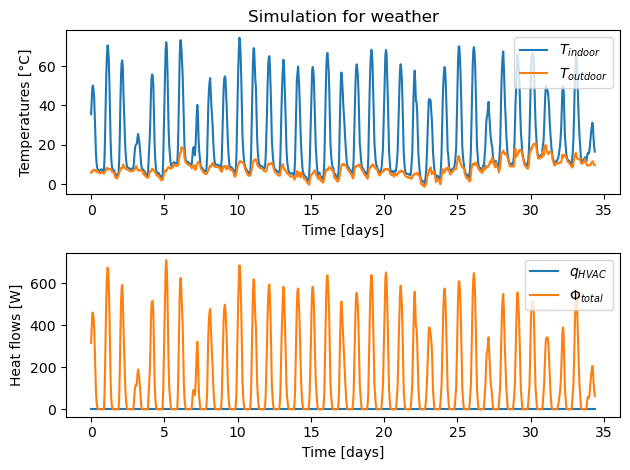

In [37]:
fig, axs = plt.subplots(2, 1)
# plot indoor and outdoor temperature
axs[0].plot(t / 3600 / 24, y_exp[0, :], label='$T_{indoor}$')
axs[0].plot(t / 3600 / 24, data['To'], label='$T_{outdoor}$')
axs[0].set(xlabel='Time [days]',
           ylabel='Temperatures [°C]',
           title='Simulation for weather')
axs[0].legend(loc='upper right')

# plot total solar radiation and HVAC heat flow
axs[1].plot(t / 3600 / 24,  q_HVAC, label='$q_{HVAC}$')
axs[1].plot(t / 3600 / 24, data['Etot'], label='$Φ_{total}$')
axs[1].set(xlabel='Time [days]',
           ylabel='Heat flows [W]')
axs[1].legend(loc='upper right')

fig.tight_layout()

Figure 6. Simulation in free-running with weather data using Euler explicit method of integration. a) Indoor and outdoor temperatures. b) Solar and HVAC heat flow rates.

## Discussion

- Necessary: Solving the problem of overheating:
    - ventilation
    - mechanical shading
    - HVAC installation
    - considering material solution for roof

- Capacities considered into the model:
    - if the capacities of the air $C_a =$ `C['Air']` and of the glass $C_g =$ `C['Glass']` are considered, then the time step is small;
    - if the capacities of the air and of the glass are zero, then the time step is large (and the order of the state-space model is reduced).